## **SML FINAL PROJECT: PCA with KNN on Fashion MNIST Dataset**
### Author - Velamuri Yoganandam
---
This file contains the implementation of PCA with KNN on Fashion MNIST Dataset
All the cells in the file must be executed in the same order for the code to run without any errors.


In [ ]:
!pip install torch
!pip install torchvision

In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
import torch, torchvision

def load_dataset():
  train_set = torchvision.datasets.FashionMNIST("./data", download=True)
  test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False)

  X_train = train_set.data.numpy()
  labels_train = train_set.targets.numpy()
  X_test = test_set.data.numpy()
  labels_test = test_set.targets.numpy()

  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
  X_train = X_train/255.0
  X_test = X_test/255.0

  return X_train, labels_train, X_test, labels_test

x_train, y_train, x_test, y_test = load_dataset()

Only preprocessing done for this dataset is scaling. All features values can take a maximum of 255 and hence the scaling value.

In [5]:
print("Train sample size: ",x_train.shape[0])
print("Test sample size : ", x_test.shape[0])

Train sample size:  60000
Test sample size :  10000


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
knn = KNeighborsClassifier()

pipe = Pipeline(
    [
        ("PCA", PCA(n_components = 0.95, svd_solver='full')),
        ("KNN", knn)
    ]
)

# Left 1 out of these values to avoid overfitting.
# Used only odd k values to avoid ties at the decision boundary
k_vals = np.arange(3, 31, 2)
pca_n_vals = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# 10-Fold Cross Validation
param_grid = {
    'KNN__n_neighbors': k_vals,
    'PCA__n_components': pca_n_vals
}

# Define the GridSearchCV object with k-fold cross-validation
grid_search = GridSearchCV(pipe, param_grid,
                           cv=5,
                           scoring='accuracy',
                           return_train_score=True,
                           verbose=2)

# Perform grid search
grid_search.fit(x_train, y_train).score(x_test, y_test)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.5; total time=  13.7s
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.5; total time=  13.4s
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.5; total time=  13.2s
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.5; total time=  13.0s
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.5; total time=  13.3s
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.6; total time=  13.5s
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.6; total time=  13.1s
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.6; total time=  13.5s
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.6; total time=  12.4s
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.6; total time=  11.4s
[CV] END ..........KNN__n_neighbors=3, PCA__n_components=0.7; total time=  12.6s
[CV] END ..........KNN__n_neighbors=3, PCA__n_

0.8623

In [9]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated score (accuracy): {:.2f}".format(grid_search.best_score_))

best_knn = grid_search.best_estimator_
test_score = best_knn.score(x_test, y_test)
print("Test set accuracy: {:.2f}".format(test_score))

print(f"Total features: {x_train.shape[1]}, Principal components chosen: {best_knn.named_steps.PCA.n_components_}")

Best parameters found:  {'KNN__n_neighbors': 5, 'PCA__n_components': 0.95}
Best cross-validated score (accuracy): 0.86
Test set accuracy: 0.86
Total features: 784, Principal components chosen: 187


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_per_hyperparam(hyperparam1, hyperparam2, hyp2_vals, label, xlabel, leg_title):
  # Retrieve the mean test scores from the cv_results
  mean_test_scores = grid_search.cv_results_['mean_test_score']
  mean_train_scores = grid_search.cv_results_['mean_train_score']

  # Get the list of hyperparameters settings from cv_results
  param_settings = [params for params in grid_search.cv_results_['params']]

  # Initialize a plot
  plt.figure(figsize=(10, 6))

  # Plot a curve for each value of PCA__n_components
  for hyp2_val in hyp2_vals:
      # Filter scores for the specific value of PCA__n_components
      scores = [mean_test_scores[i] for i in range(len(param_settings))
                if param_settings[i][hyperparam2] == hyp2_val]

      # Extract the KNN__n_neighbors values for plotting
      neighbors_values = [param_settings[i][hyperparam1] for i in range(len(param_settings))
                          if param_settings[i][hyperparam2] == hyp2_val]
      # Plot accuracy on y-axis and hyperparameters on x-axis
      plt.plot(neighbors_values, scores, marker='o', label=f'{label}={hyp2_val}')
  # Label the axes
  plt.xlabel(xlabel=xlabel)
  plt.ylabel('Accuracy')
  plt.title('Test Accuracy vs. Number of Neighbors')

  # Show the legend
  plt.legend(loc='upper left', bbox_to_anchor=(1,1), title=leg_title)
  plt.tight_layout()

  # Show the plot
  plt.show()

  plt.figure(figsize=(10, 6))
  for hyp2_val in hyp2_vals:
      # Filter scores for the specific value of PCA__n_components
      scores = [mean_train_scores[i] for i in range(len(param_settings))
                if param_settings[i][hyperparam2] == hyp2_val]

      # Extract the KNN__n_neighbors values for plotting
      neighbors_values = [param_settings[i][hyperparam1] for i in range(len(param_settings))
                          if param_settings[i][hyperparam2] == hyp2_val]
      plt.plot(neighbors_values, scores, marker='o', label=f'{label}={np.round(hyp2_val,2)}')
  # Label the axes
  plt.xlabel(xlabel=xlabel)
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy vs. Number of Neighbors')

  # Show the legend
  plt.legend(loc='upper left', bbox_to_anchor=(1,1), title=leg_title)
  plt.tight_layout()

  # Show the plot
  plt.show()


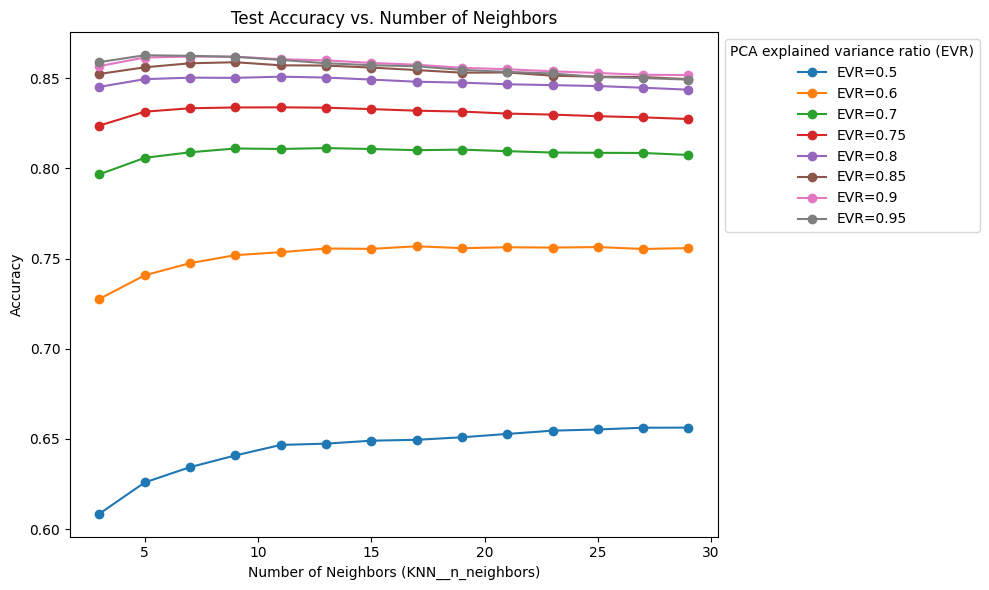

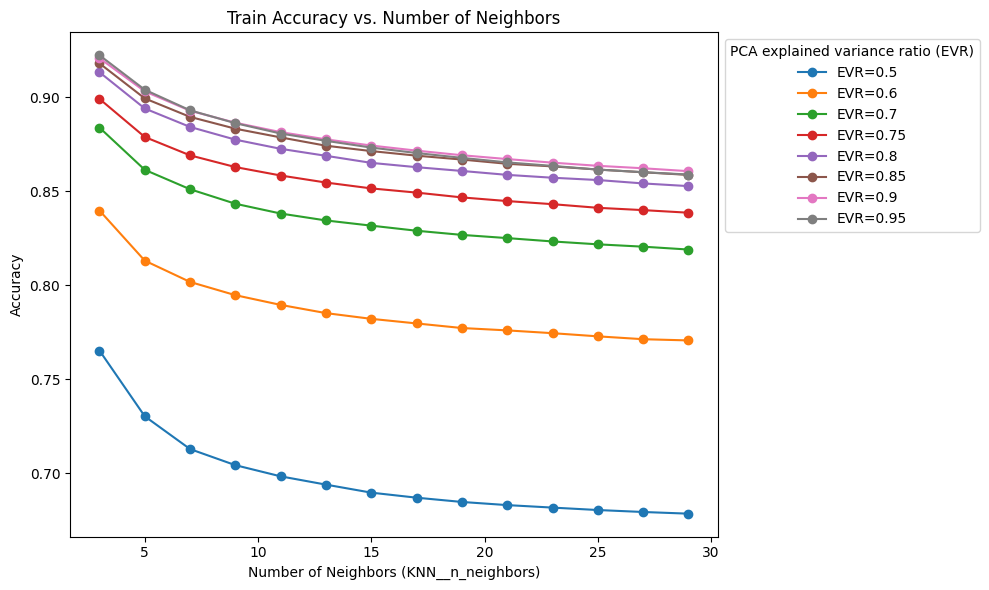

In [11]:
plot_per_hyperparam('KNN__n_neighbors', 'PCA__n_components', pca_n_vals, 'EVR', 'Number of Neighbors (KNN__n_neighbors)', 'PCA explained variance ratio (EVR)')

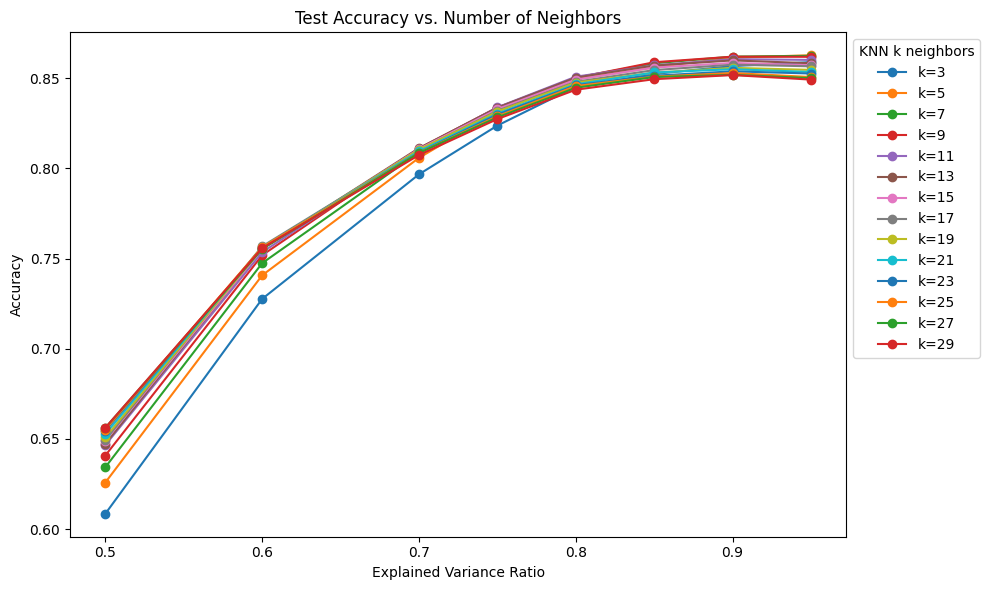

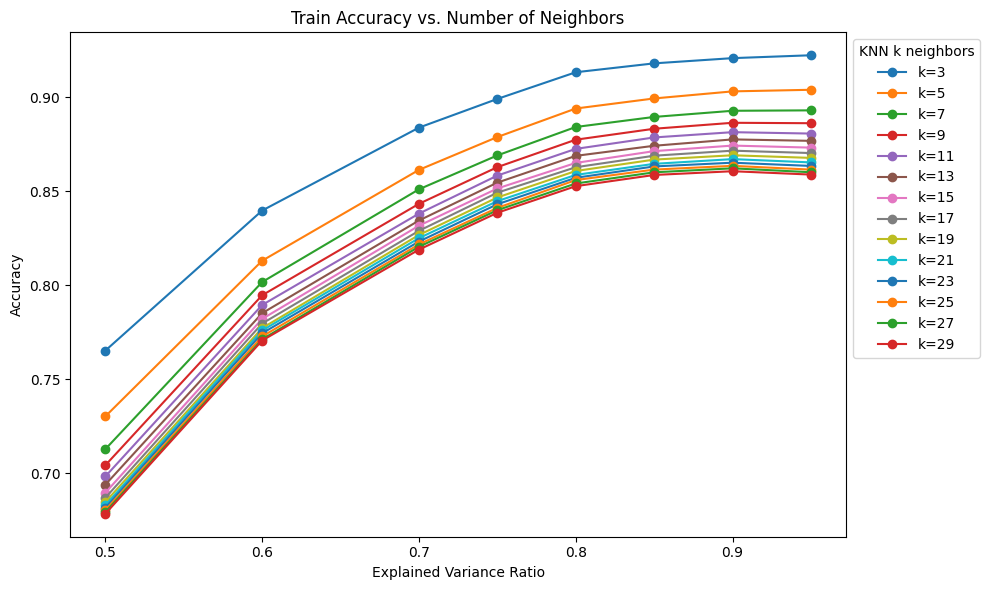

In [12]:
plot_per_hyperparam('PCA__n_components', 'KNN__n_neighbors', k_vals, 'k', 'Explained Variance Ratio', 'KNN k neighbors')

<Axes: >

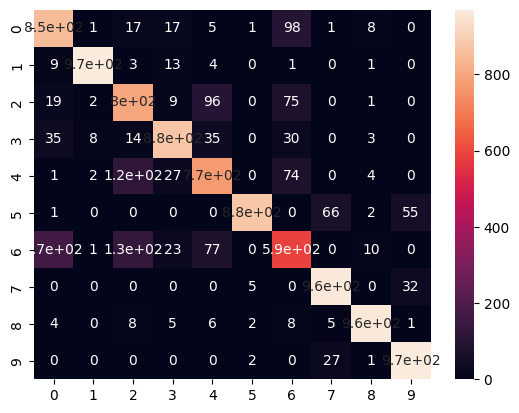

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
best_model = best_knn
y_predict_scaled = best_knn.predict(x_test)
cm = confusion_matrix(y_test, y_predict_scaled)
sns.heatmap(cm, annot=True)